# Spectroscopic Case

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import numpy as np
%matplotlib inline
from tqdm import tqdm
from zbeamsfunctions import mu_w,likelihood,likelihood_spec
from mcmcfunctions import mcmc,mcmc_spec
from scipy.stats import truncnorm
import pandas as pd
from mcmcfunctions import mcmc_phot
from mcmcfunctions_SL import mcmc_SL
from zbeamsfunctions_SL import likelihood_SL,likelihood_spec_contam_SL,contour,r_SL

from Lenstronomy_Cosmology import Background, LensCosmo
from astropy.cosmology import LambdaCDM,FlatLambdaCDM,wCDM,FlatwCDM
import corner
import sys, importlib

try:importlib.reload(sys.modules['mcmcfunctions_SL'])
except Exception as ex: print(f'Cannot reload: {ex}')

In [3]:
zt,z_obs,z2,mu_t,mu_obs,cor_type,cor_z  = np.loadtxt('fakedata_spectroscopic.txt',unpack=True)

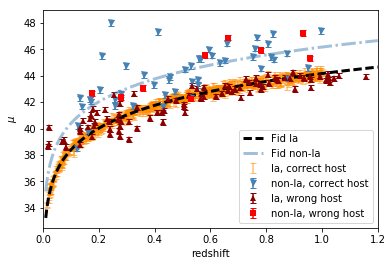

In [38]:
index_Ia = np.where((cor_type==1) & (cor_z==1))
index_nIa = np.where((cor_type==0) & (cor_z==1))
index_zIa = np.where((cor_type==1) & (cor_z==0))
index_znIa = np.where((cor_type==0) & (cor_z==0))

plt.errorbar(z_obs[index_Ia],mu_obs[index_Ia],yerr=0.2*np.ones(len(mu_obs[index_Ia])),
             marker='',ls='',color='darkorange', alpha=0.55,ms=7,capsize=3,
             label='Ia, correct host')
plt.errorbar(z_obs[index_nIa],mu_obs[index_nIa],yerr=0.2*np.ones(len(mu_obs[index_nIa])),
             marker='v',ls='',color='steelblue',markeredgecolor='none',ms=7,capsize=3,
             label='non-Ia, correct host')
plt.errorbar(z_obs[index_zIa],mu_obs[index_zIa],yerr=0.2*np.ones(len(mu_obs[index_zIa])),
             marker='^',ls='',color='darkred',markeredgecolor='none',ms=6,capsize=3,
             label='Ia, wrong host')
plt.errorbar(z_obs[index_znIa],mu_obs[index_znIa],yerr=0.2*np.ones(len(mu_obs[index_znIa])),
             marker='s',ls='',color='r',markeredgecolor='none',ms=6,capsize=3,
             label='non-Ia, wrong host')

z_vec = np.linspace(.01,1.2,1000)
mu_vec = np.vectorize(mu_w)
plt.plot(z_vec,mu_vec(z_vec,0.31,67.74,-1),'--k',lw=3,label='Fid Ia')
plt.plot(z_vec,mu_vec(z_vec,0.31,67.74,-1)+2,'-.',color='steelblue',lw=3,alpha=0.5,label='Fid non-Ia')

plt.xlabel('redshift')
plt.ylabel(r'$\mu$')
plt.legend()
plt.xlim([0,1.2])

plt.show()

In [4]:
#generating the unbiased mcmc chain

mcmc(50000,                          #number of steps
     likelihood,                     #which likelihood function to use
     'nobias',                       #bias: indicates the z dataset to use
     'nobias',                       #bias: indicates the mu dataset to use
     0.3,70,-1,                      #starting points (OMi,H0i,wi)
     0.0295,0.3965,0.0785,           #step sizes (omstep,H0step,wstep)
     'fakedata_spectroscopic.txt',   #input file (dataset)
     'chains/mcmc_chain_nobias.txt', #output file (chain)
     True)                           #show the statusbar 

Generating posterior
[##################################################]100%
done


In [25]:
#zL_obs=db_in['zL_obs'];zS_obs=db_in['zS_obs'];r_obs=db_in['r_obs'];sigma_r_obs=db_in['sigma_r_obs'] #Making these up!!!

repeat_0=True

N_obs = 10000
zL_obs_0 = []
zS_obs_0 = []
repeat_0=True
while repeat_0:
    zL_obs_i = truncnorm(-2,np.inf,loc=0.5,scale = 0.25).rvs(size=10*N_obs)
    zS_obs_i = truncnorm(-2,np.inf,loc=1,scale=0.5).rvs(size=10*N_obs)
    valid_bool = zL_obs_i<zS_obs_i
    zL_obs_i=zL_obs_i[valid_bool]
    zS_obs_i=zS_obs_i[valid_bool]
    if len(zL_obs_i)>=N_obs:
        zL_obs_0 = zL_obs_i[0:N_obs]
        zS_obs_0 = zS_obs_i[0:N_obs]
        assert len(zL_obs_0)==N_obs;assert len(zS_obs_0)==N_obs
        repeat_0=False

Om_fid = 0.3;Ode_fid = 0.7;H0_fid = 70;w_fid = -1.0

cosmo_type = 'wCDM'
'''
NOTE: I think this may currently be incorrect - r_obs_0 should be measured from theta_E and vel_disp, rather than redshifts?
'''
if cosmo_type == 'wCDM': r_obs_0 = r_SL(zL_obs_0,zS_obs_0,wCDM(H0=H0_fid,Om0=Om_fid,Ode0=Ode_fid,w0=w_fid))
if cosmo_type == 'FlatwCDM': r_obs_0 = r_SL(zL_obs_0,zS_obs_0,FlatwCDM(H0=H0_fid,Om0=Om_fid,w0=w_fid))
if cosmo_type == 'LambdaCDM': r_obs_0 = r_SL(zL_obs_0,zS_obs_0,LambdaCDM(H0=H0_fid,Om0=Om_fid,Ode0=Ode_fid))
if cosmo_type == 'FlatLambdaCDM': r_obs_0 = r_SL(zL_obs_0,zS_obs_0,FlatLambdaCDM(H0=H0_fid,Om0=Om_fid))

#Breaking the measurements of r_obs if the object is contaminated:
p_tau_0 = [np.random.choice([0.8,1.0]) for i in range(len(r_obs_0))]
contaminated_bool_0 = [np.random.choice([0,1],p=[p_tau_0[i],1-p_tau_0[i]]) for i in range(len(r_obs_0))] #Lens = 0
r_obs_0_contam = [r_obs_0[i] if contaminated_bool_0[i] == 0 else np.random.random() for i in range(len(r_obs_0))]

'''
Not sure what sigma_r_obs_0 should be if the object is not a lens?
'''

sigma_r_obs_0 = abs(0.05*r_obs_0)

db_in = pd.DataFrame({'zL_obs':zL_obs_0,'zS_obs':zS_obs_0,
                    'r_obs':r_obs_0,'r_obs_contam': r_obs_0_contam,
                    'sigma_r_obs':sigma_r_obs_0,'P_tau':p_tau_0})
db_in.head(5)
db_in.describe()

,zL_obs,zS_obs,r_obs,r_obs_contam,sigma_r_obs,P_tau
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.478840,1.144504,0.476643,0.479182,0.023832,0.901200
std,0.224793,0.408725,0.225661,0.233330,0.011283,0.099998
min,0.000627,0.065473,0.000082,0.000082,0.000004,0.800000
25%,0.313584,0.852803,0.311692,0.307146,0.015585,0.800000
50%,0.472383,1.108535,0.476550,0.477270,0.023827,1.000000
75%,0.631554,1.414139,0.641026,0.650288,0.032051,1.000000
max,1.285762,2.949181,0.997834,0.999559,0.049892,1.000000


In [3]:
zL_err = [0.99,1.01]
zS_err = [0.99,1.01]
'''
r_obs_c_err = r_SL(
        zL_obs_0*np.random.uniform(low=zL_err[0],high=zL_err[1],size=len(zL_obs_0)),
        zS_obs_0*np.random.uniform(low=zS_err[0],high=zS_err[1],size=len(zL_obs_0)),
        wCDM(H0=H0_fid,Om0=Om_fid,Ode0=Ode_fid,w0=w_fid))'''

'\nr_obs_c_err = r_SL(\n        zL_obs_0*np.random.uniform(low=zL_err[0],high=zL_err[1],size=len(zL_obs_0)),\n        zS_obs_0*np.random.uniform(low=zS_err[0],high=zS_err[1],size=len(zL_obs_0)),\n        wCDM(H0=H0_fid,Om0=Om_fid,Ode0=Ode_fid,w0=w_fid))'

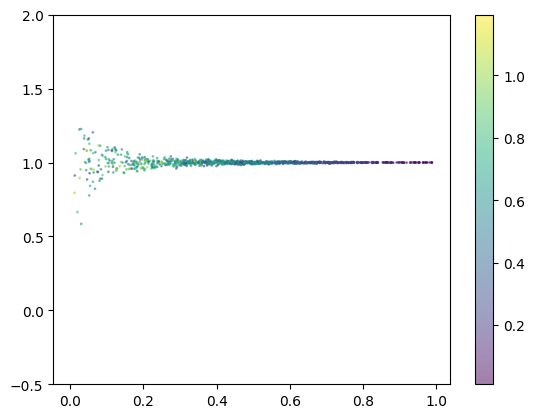

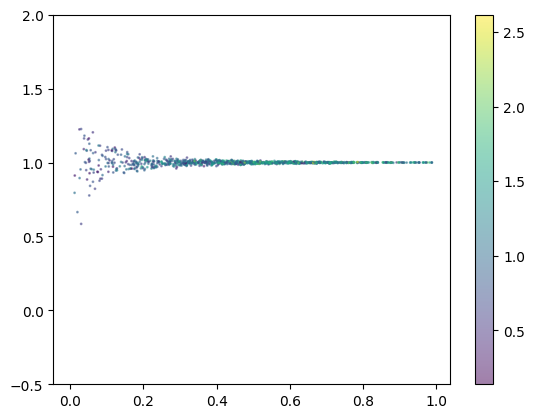

In [57]:
plt.scatter(r_obs_0,r_obs_c_err/r_obs_0,alpha=0.5,s=1,c=zL_obs_0)
plt.colorbar()
plt.ylim(-0.5,2)
plt.show()
plt.scatter(r_obs_0,r_obs_c_err/r_obs_0,alpha=0.5,s=1,c=zS_obs_0)
plt.colorbar()
plt.ylim(-0.5,2)
plt.show()

# = Plot of how much information does zL, zS provide?

In [26]:
['FlatLambdaCDM','LambdaCDM','FlatwCDM','wCDM']

mcmc_SL(
     n = 1000,
     likelihood = likelihood_spec_contam_SL, #likelihood_SL
     zbias = 'bias',
     mubias = 'bias',
     OMi = 0.3,
     Odei = 0.7,
     H0i = 70,
     wi = -1,
     omstep = 0.01,
     ode_step = 0.01,
     H0step = 1,
     wstep = 0.01,
     db_in = db_in, #input file (dataset)
     fileout = 'chains/mcmc_chains_SL_orig.txt',
     status = True,
     cosmo_type = cosmo_type)

Allowing the cosmology to have non-zero curvature
Assuming Non-trivial DE EoS
Generating posterior
[##################################################]100%
done


In [ ]:
#generating the biased mcmc chain

mcmc(50000,                            #number of steps
     likelihood,                       #which likelihood function to use
     'bias',                           #bias: indicates the z dataset to use
     'bias',                           #bias: indicates the mu dataset to use
     0.3,70,-1,                        #starting points (OMi,H0i,wi)
     0.0295,0.3965,0.0785,             #step sizes (omstep,H0step,wstep)
     'fakedata_spectroscopic.txt',     #input file (dataset)
     'chains/mcmc_chain_bias_muo.txt', #output file (chain)
     True)                             #show the statusbar 

In [3]:
#generating the zBEAMS mcmc chain

mcmc_spec(50000,                         #number of steps
         likelihood_spec,                #which likelihood function to use
         'bias',                         #bias: indicates the mu dataset to use
         0.3,70,-1,                      #starting points (OMi,H0i,wi)
         0.0295,0.3965,0.0785,           #step sizes (omstep,H0step,wstep)
         'fakedata_spectroscopic.txt',   #input file (dataset)
         'chains/mcmc_chain_zBEAMS.txt', #output file (chain)
         True)                           #show the statusbar 

Generating posterior
[##################################################]100%
done


In [66]:
#!python3 -m pip install arviz
import arviz as az
#az.style.use("arviz-plasmish")
az.style.use('arviz-doc')
#az.style.available

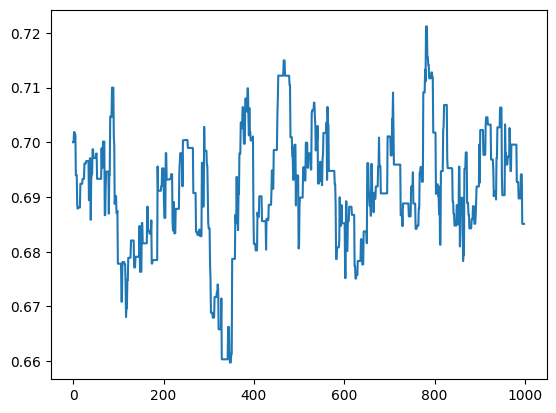

In [24]:
import matplotlib.pyplot as pl
pl.plot(mcmc_chains_SL_orig['Ode'])

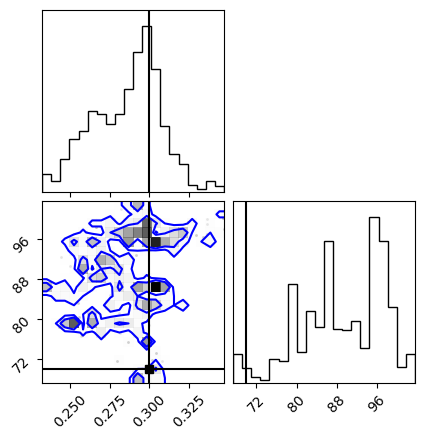

In [17]:
mcmc_chains_SL_orig = pd.read_csv('chains/mcmc_chains_SL_orig.txt',delimiter='\t')
mcmc_chains_SL_orig = mcmc_chains_SL_orig.rename(columns={'#o_m':'o_m'})

#nb_mcmc_file = 'chains/mcmc_chain_nobias.txt'
#bi_mcmc_file = 'chains/mcmc_chain_bias_muo.txt'
#zb_mcmc_file = 'chains/mcmc_chain_zBEAMS.txt'

#om_nb,H0_nb,w_nb = np.loadtxt(nb_mcmc_file, usecols=[0,1,2],unpack=True)
#om_bi,H0_bi,w_bi = np.loadtxt(bi_mcmc_file, usecols=[0,1,2],unpack=True)
#om_zb,H0_zb,w_zb = np.loadtxt(zb_mcmc_file, usecols=[0,1,2],unpack=True)
om_bi = mcmc_chains_SL_orig['o_m']
H0_bi = mcmc_chains_SL_orig['H0']
w_bi = mcmc_chains_SL_orig['w']
Ode_bi = mcmc_chains_SL_orig['Ode']

X_param = 'o_m'
Y_param = 'H0'
X_fid = {'o_m':Om_fid,'H0':H0_fid,'Om':Om_fid,'Ode':Ode_fid,'w':w_fid}[X_param]
Y_fid = {'o_m':Om_fid,'H0':H0_fid,'Om':Om_fid,'Ode':Ode_fid,'w':w_fid}[Y_param]

fig = plt.figure(figsize=(5,5))
corner.corner(mcmc_chains_SL_orig[[X_param,Y_param]].to_numpy(),
                truths = [X_fid,Y_fid],
                truth_color='k',
                contour_kwargs = {'colors':'blue'},
                #fill_contours=True,
                #contourf_kwargs = {'alpha':0.5},
                levels=[0.68,0.95],fig=fig)

plt.show()